precipitation_(%)       1.000000
humidity                0.638631
wind_speed              0.443770
atmospheric_pressure   -0.177444
temperature            -0.287206
uv_index               -0.291601
visibility_(km)        -0.457444
Name: precipitation_(%), dtype: float64


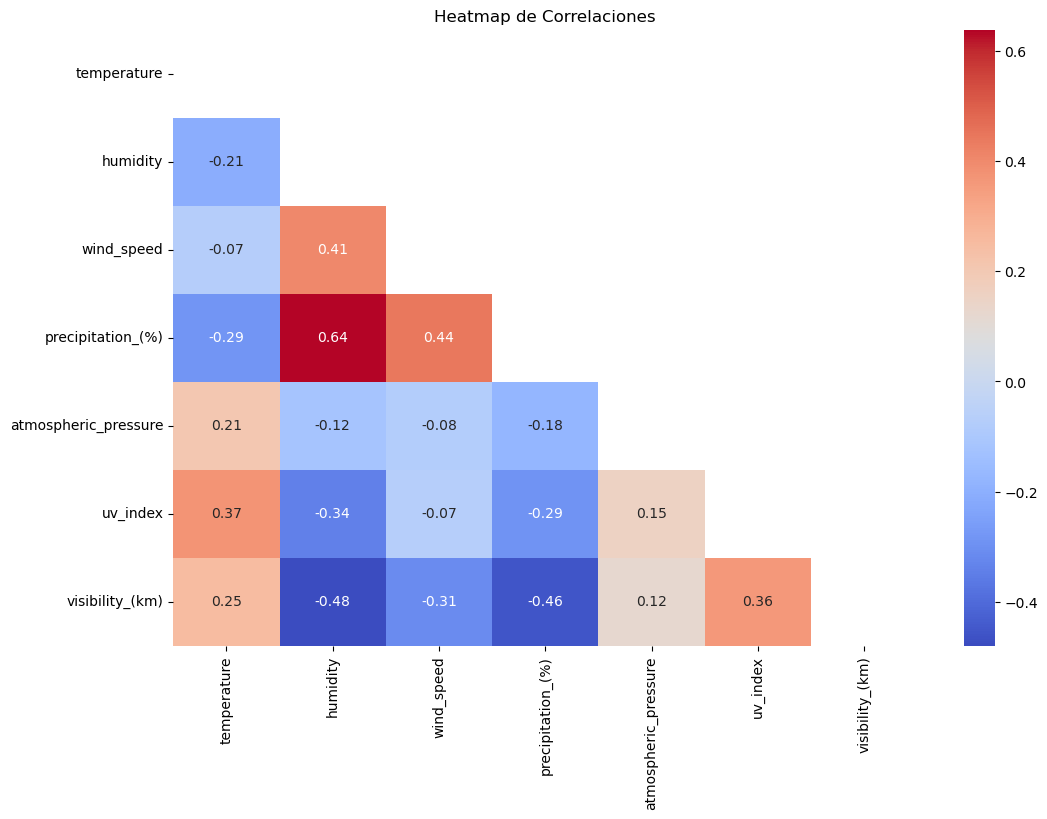

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mean Squared Error: 227.90
R^2 Score: 0.78


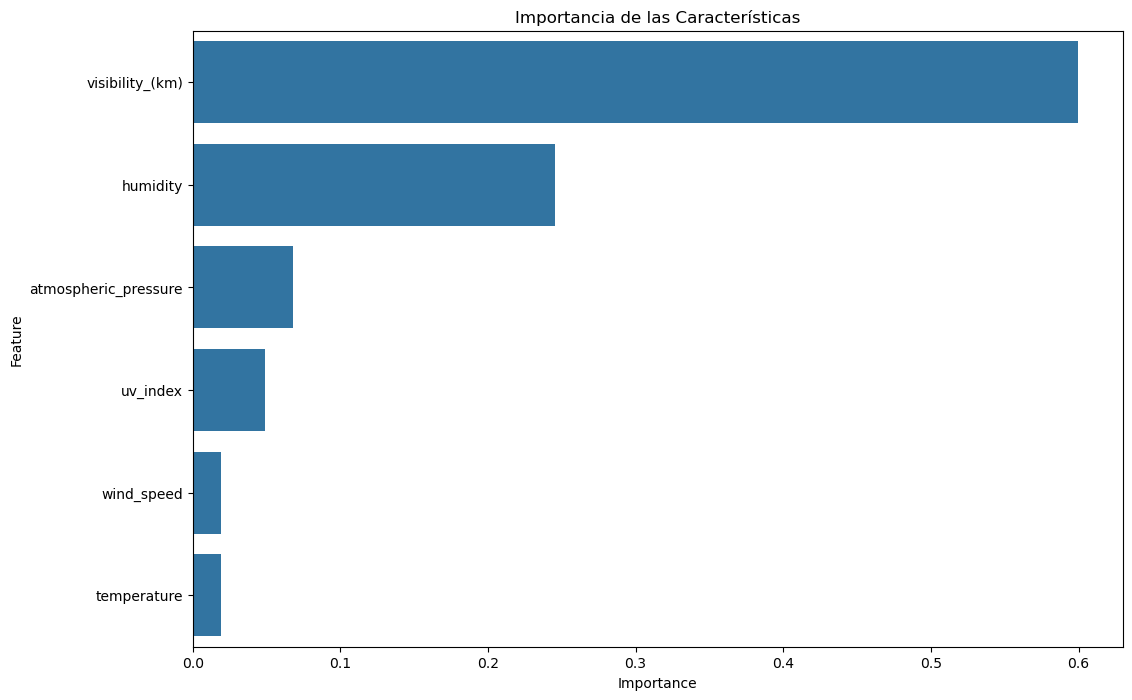

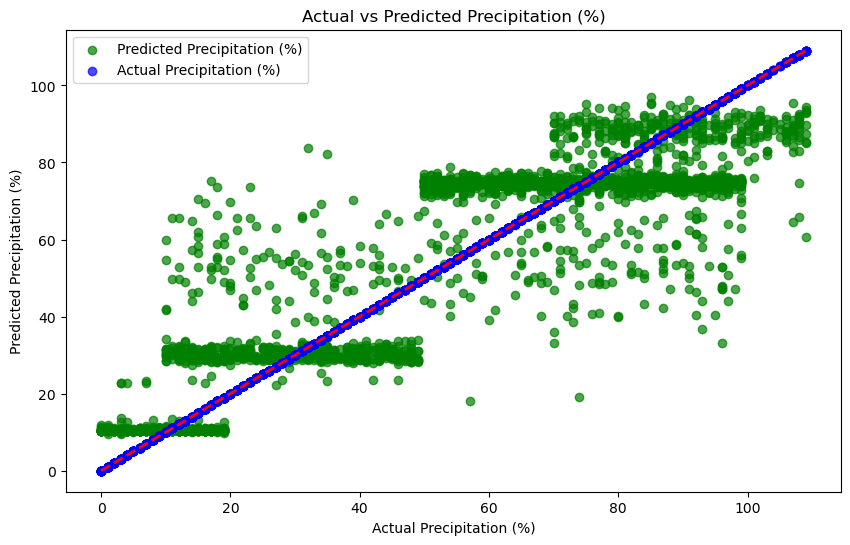

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Preprocesar los datos
# Codificar variables categóricas
# label_encoder = LabelEncoder()
# categorical_columns = ['cloud_cover', 'season', 'location', 'weather_type']
# for column in categorical_columns:
#     data[column] = label_encoder.fit_transform(data[column])

data = data.drop(['weather_type', 'season', 'location', 'cloud_cover'], axis=1)

# Seleccionar variable objetivo
target = 'precipitation_(%)'

# Mostrar la correlación entre las características y el objetivo
correlation = data.corr()
print(correlation[target].sort_values(ascending=False))

# Visualizar el heatmap de correlaciones
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Heatmap de Correlaciones')
plt.show()

# Separar características y etiquetas
X = data.drop(target, axis=1)
y = data[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar los parámetros del Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
gbr = GradientBoostingRegressor(**best_params)
gbr.fit(X_train_scaled, y_train)

# Predecir
y_pred = gbr.predict(X_test_scaled)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Importancia de las características
feature_importances = gbr.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green', label='Predicted Precipitation (%)')
plt.scatter(y_test, y_test, alpha=0.7, color='blue', label='Actual Precipitation (%)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Precipitation (%)')
plt.ylabel('Predicted Precipitation (%)')
plt.title('Actual vs Predicted Precipitation (%)')
plt.legend()
plt.show()